# 4. Confusion matrix

## 1. Best learned models

In [1]:
import glob
import pandas as pd

# Load data
files = glob.glob('../evaluate_results/outer/*.csv', recursive=True)
data = pd.concat([pd.read_csv(file, index_col=[0]) for file in files])

# Filter metric
data_sorted = data[data['metric'] == 'accuracy']

# Mean and sort values
data_sorted = data_sorted.groupby(['model', 'best_params', 'split_method', 'i_outer', 'metric']) \
    .mean() \
    .sort_values('value', ascending=False) \
    [['value']]

# Maintain only best params
data_sorted = data_sorted.reset_index(['best_params', 'split_method', 'i_outer'])
data_sorted = data_sorted[~data_sorted.index.duplicated(keep='first')]

# Reindex
data_sorted.reset_index().set_index(['model', 'best_params', 'metric', 'split_method', 'i_outer'])

,,,,,value
model,best_params,metric,split_method,i_outer,
SVC,"{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}",accuracy,split_x_y_split_with_one_hot_encoding,1,0.409722
LogisticRegression,{},accuracy,split_x_y_split_with_one_hot_encoding,0,0.404157
KNeighborsClassifier,"{'algorithm': 'brute', 'metric': 'hamming', 'n_neighbors': 25}",accuracy,split_x_y_split_with_one_hot_encoding,1,0.373843


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

models = [
    [KNeighborsClassifier, 1, {'algorithm': 'brute', 'metric': 'hamming', 'n_neighbors': 25}],
    [svm.SVC, 1, {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}],
    [LogisticRegression, 0, {'multi_class': 'auto', 'solver': 'liblinear'}],
]

## 2. Plot confusion matrix

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 10]

import numpy as np
import pandas as pd

import seaborn as sns

from rbm.train.kfold_elements import KFoldElements

from experiments.other_models.utils import plot_confusion_matrix

In [7]:
def split_x_y(data, y_column):
    n_samples, n_columns = data.shape

    columns = [f'plugin{i}' for i in range(1, n_columns + 1)]
    train_columns = columns[0:y_column] + columns[y_column + 1:n_columns + 1]
    test_column = f'plugin{y_column + 1}'

    return data[train_columns], data[test_column]

In [8]:
def plot(Model, kfold, params):
    data = pd.read_csv('../data/patches-filtered.csv', sep=",", index_col=['id', 'name'])
    
    kfolds = KFoldElements(data=data, n_splits=5, random_state=42, shuffle=False)

    model = Model(**params)

    for index, train, test in kfolds.split():
        if index != kfold:
            continue

        ys = []
        y_predicts = []

        for column in range(0, 6):
            X, y = split_x_y(train, column)

            model.fit(X, y)
            X_test, y_test = split_x_y(test, column)

            ys.append(y_test)
            y_predicts.append(model.predict(X_test))

        break
    
    return ys, y_predicts

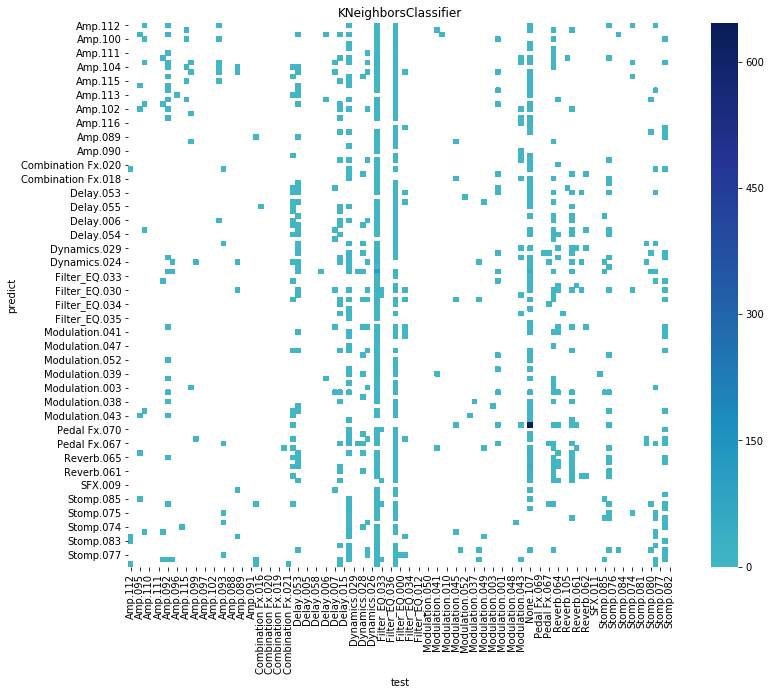

In [10]:
categories = pd.read_csv('../data/plugins_categories_simplified.csv').sort_values(['category', 'name'])
categories['new_id'] = categories.category + '.' + categories.id.astype(str).str.rjust(3, '0')

ys, y_predicts = plot(*models[0])
plot_confusion_matrix(models[0][0].__name__, ys, y_predicts, categories.id, categories.new_id)

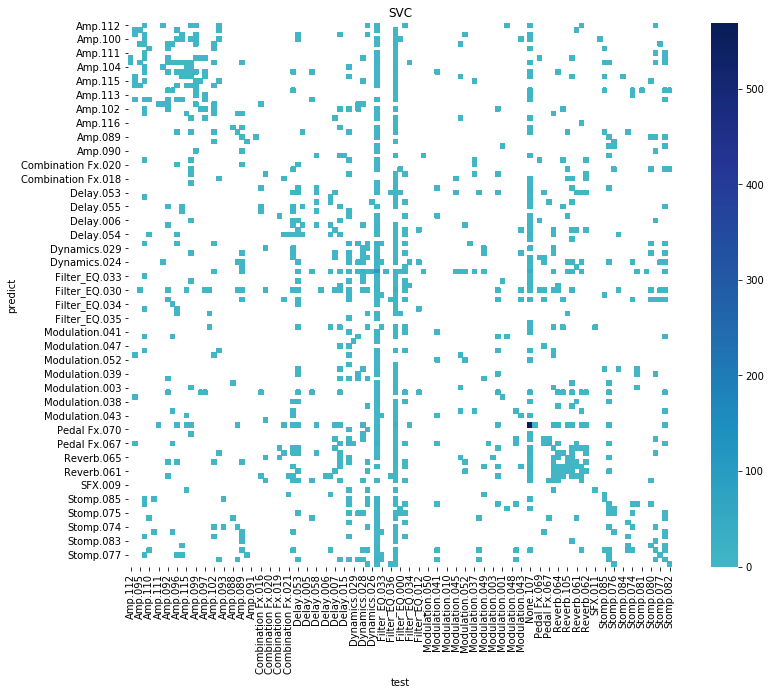

In [11]:
ys, y_predicts = plot(*models[1])
plot_confusion_matrix(models[1][0].__name__, ys, y_predicts, categories.id, categories.new_id)

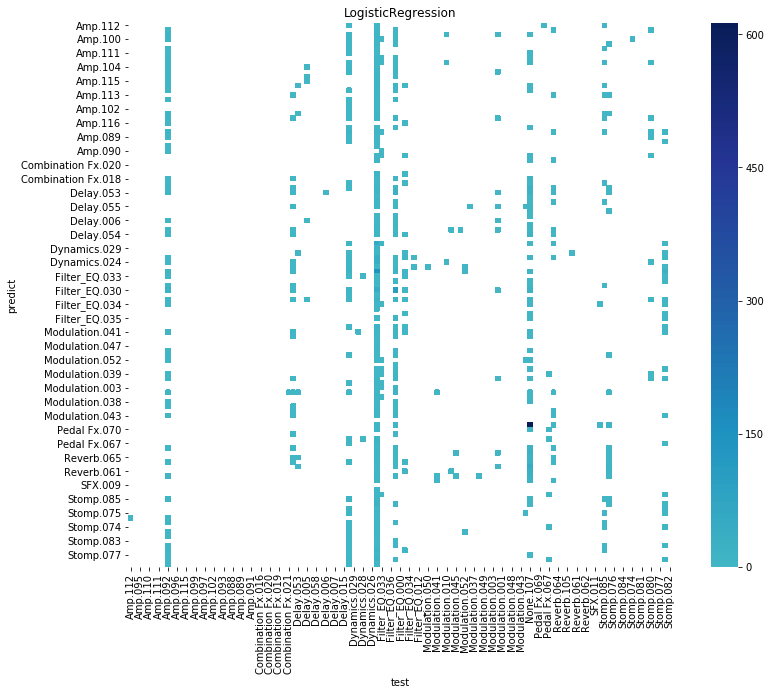

In [12]:
ys, y_predicts = plot(*models[2])
ax = plot_confusion_matrix(models[2][0].__name__, ys, y_predicts, categories.id, categories.new_id)